# Capstone project: Heartbeat Sounds Classification
Classifying heartbeat anomalies from stethoscope audio
**Kaggle: Challenge 2**

# Problem Statement:
Stethoscope is good in detecting the first warning signs of heart disease. However, this is always done by frontline health workers, mostly when we are sick or during our annual physical examination. Although digital stethoscopes is available but we still need healthcare professional to determine whether an individual is having hearbeat irregularities or abnormalities and need for further check-up. 
It is well known that early detection and intervention in heart disease (or any disease) will greatly imporves the lifespan and the effectiveness of treatment options. 

The **goal** of this project is to use machine learning methods to identify and **classify heartbeat sounds** from audio collected from stethoscopes into normal versus various non-normal heartbeat sounds.


### Target Audience:
1. Untrained frontline health workers to help determine whether an individual should bre reffered to expert diagnosis.
2. Consumer who can frequently check their respiratory health or constantly monitor if there is an heartbeat irregularities that prompt them to seek treatment in early stage. 

### Success Metric
Model selections: Supervised Classification: CNN (convolutional neural network), RNN (recurrent neural network) 

Evaluation metric: Accuracy, Precision, Youden's Index, F1-score

### Data Source
[kaggle dataset: Heartbeat Sounds](https://www.kaggle.com/kinguistics/heartbeat-sounds)

### Potential Challenge
1. No experience in handling of unstructure audio data and its extra step for pre-processing, features extraction
2. Not the domain expert in respiratory health

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.signal import welch

## audio
import librosa as lr
from librosa import display
import wave                    # library handles the parsing of WAV file headers
import pywt
import IPython.display as ipd  #audio playback

## plot
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import itertools

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

## keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Task 2: Heart Sound Segmentation

The task is to produce a method that can **classify the unlabeled real heart audio** (also known as “beat classification”) into the correct categories after training on both dataset A and dataset B.
Four categories in dataset A:

|Dataset|Number of Categories|Categories|Sources|Recorded by|
|---|---|---|---|---|
|A|4|Normal, Murmur, Extra Heart Sound, Artifact|general public|iStethoscope Pro iPhone app|
|B|3|Normal, Murmur, Extrsystole|clinic trial in hospitals|digital stethoscope|

- audio files - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

# 1 Data Cleaning and Exploratory Data Analysis (EDA)

## List all datasets downloaded for Task 2
- two sets of wav files (set_a, set_b)
- three csv files (set_a, set_b, and set_a_timing)

In [2]:
ls ../datasets/challenge2/

set_a/            set_a_timing.csv* set_b.csv*
set_a.csv*        set_b/


In [3]:
ls ../datasets/challenge2/set_a/

Aunlabelledtest__201012172010.wav* artifact__201106211430.wav*
Aunlabelledtest__201101051105.wav* artifact__201106212112.wav*
Aunlabelledtest__201101061552.wav* artifact__201106220340.wav*
Aunlabelledtest__201101091156.wav* artifact__201106221254.wav*
Aunlabelledtest__201101110659.wav* extrahls__201101070953.wav*
Aunlabelledtest__201101152256.wav* extrahls__201101091153.wav*
Aunlabelledtest__201101220549.wav* extrahls__201101152255.wav*
Aunlabelledtest__201101241434.wav* extrahls__201101160804.wav*
Aunlabelledtest__201102081033.wav* extrahls__201101160808.wav*
Aunlabelledtest__201102081045.wav* extrahls__201101161027.wav*
Aunlabelledtest__201102200848.wav* extrahls__201101241423.wav*
Aunlabelledtest__201103011036.wav* extrahls__201101241433.wav*
Aunlabelledtest__201103140236.wav* extrahls__201102070251.wav*
Aunlabelledtest__201103170122.wav* extrahls__201102071835.wav*
Aunlabelledtest__201103200518.wav* extrahls__201102241217.wav*
Aunlabelledtest__201103201314.wav* extrahls__2011031501

## 1.1 EDA : csv file

Explore the information provided by the 3 csv files

In [4]:
## load and explore set_a
set_a = pd.read_csv('../datasets/challenge2/set_a.csv')
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [5]:
### 4 columns in set a, with all null value in 'sublabel' column
set_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   176 non-null    object 
 1   fname     176 non-null    object 
 2   label     124 non-null    object 
 3   sublabel  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


In [6]:
### there are 52 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category
set_a.isnull().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [7]:
### There are 4 categories in set_a: artifact, extrahls, murmur, and normal heartbeat
set_a['label'].unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

In [8]:
## load and explore set_b
set_b = pd.read_csv('../datasets/challenge2/set_b.csv')
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [9]:
### Similarly, 4 columns in set a, there are some info in 'sublabel' column (not all null in set_a)
set_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dataset   656 non-null    object
 1   fname     656 non-null    object
 2   label     461 non-null    object
 3   sublabel  149 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In [10]:
### there are 195 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category

set_b.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

In [11]:
### There are 3 categories in set_a: extrastole, murmur, and normal heartbeat
set_b['label'].unique()

array(['extrastole', 'murmur', 'normal', nan], dtype=object)

**`sublabel`** column

This column label those wav with extra amount of background noise.

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

Dataset B contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. You may choose to use this or ignore it. However the test set will include some equally noisy examples.

In [12]:
### some of the wav file from 'murmur' or 'normal' categories have extra background noise
set_b['sublabel'].unique()

array([nan, 'noisymurmur', 'noisynormal'], dtype=object)

In [13]:
### load and explore set_a_timing
### this csv file contains 21 wav file with their S1 & S2 location in the wavv.
timing = pd.read_csv('../datasets/challenge2/set_a_timing.csv')

print(f' number of unique fname: {timing.fname.nunique()}')
timing.head()

 number of unique fname: 21


fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992

In [14]:
### no null avlue in this csv file
timing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fname     390 non-null    object
 1   cycle     390 non-null    int64 
 2   sound     390 non-null    object
 3   location  390 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.3+ KB


### Combine set_a & set_b csv files

There are total of 832 wav files, with **585** labeled (training set), and **247** unlabeled (test set).

**351** out of 585 labeled wav files are from `normal` category.

In [15]:
set_ab = pd.concat([set_a, set_b])
set_ab.describe()

dataset                                            fname   label  \
count      832                                              832     585   
unique       2                                              832       5   
top          b  set_b/Btraining_normal_106_1306776721273_B1.wav  normal   
freq       656                                                1     351   

           sublabel  
count           149  
unique            2  
top     noisynormal  
freq            120

In [16]:
set_ab.isnull().sum()

dataset       0
fname         0
label       247
sublabel    683
dtype: int64

### Distribution of the heartbeat sound files per category

- `normal` heartbeat category is the majority class, with 351 out of total 585 (60%)
- `extrahls` heartbeat category is the minority class, with only 19 (3.2%)

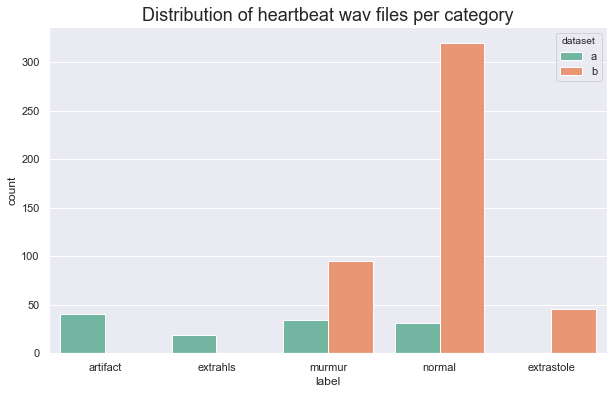

In [17]:
sns.set(style="darkgrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(x='label', hue = 'dataset', data = set_ab, palette="Set2");
ax.set_title('Distribution of heartbeat wav files per category', fontsize = 18);

In [18]:
### Get the count number per category
set_ab.groupby('label').count()

dataset  fname  sublabel
label                               
artifact         40     40         0
extrahls         19     19         0
extrastole       46     46         0
murmur          129    129        29
normal          351    351       120

In [19]:
### Percentage per category
set_ab.groupby('label')['dataset'].count()/585*100

label
artifact       6.837607
extrahls       3.247863
extrastole     7.863248
murmur        22.051282
normal        60.000000
Name: dataset, dtype: float64

## 1.2 EDA - Audio files


### Compile list of audio wav files in Atraining & Btraining folders

The **glob module** finds all the pathnames matching a specified pattern according to the rules used by the 
Unix shell, although results are returned in arbitrary order. 

use `glob()` to return a list of audio wav files that match the wav files' name in folder that store them.

In [20]:
### set_a folder
wav_dir_set_a = '../datasets/challenge2/set_a/'
a_wav = glob(wav_dir_set_a + '/*.wav')
print(f'Total wav file in set_a folder :{len(a_wav)}')

Total wav file in set_a folder :176


In [21]:
### set_b folder:
wav_dir_set_b = '../datasets/challenge2/set_b/'
b_wav = glob(wav_dir_set_b + '/*.wav')
print(f'Total wav file in set_b folder :{len(b_wav)}')

Total wav file in set_b folder :656


### Getting basic information on the audio wav files

In both set_a and set_b folders, they consist of heartbeat sounds from different categories and stored as **WAV** files.

In general, uncompressed audio is stored as a sequence of numbers that indicate the amplitude of the recorded sound pressure at each time point. In the WAV standard, these numbers are packed into a bytestring. The interpretation of this bytestring depends primarily on two factors: 
1. Sampling rate (framerate), usually given in Hertz, which indicates how many number samples comprise in one second's worth of data. 
2. Bit depth (sample width), number of bytes per sample.

On top of the two listed above, WAV file parameters include number of channels. Typically, they have 1 (mono) or 2 (for stereo). The data of a WAV file is given as a sequence of frames. A frame consists of samples. There is one sample per channel, per frame. Every wav file has a sample width, or, the number of bytes per sample. Typically this is either 1 or 2 bytes.

The `wave` library handles the parsing of WAV file headers, which include the parameters mentioned above. 

**set_a**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 44.1kHz

**set_b**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 4kHz

In [22]:
### set_a
f = wave.open(a_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=349958, comptype='NONE', compname='not compressed')

In [23]:
### set_b
f = wave.open(b_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=16188, comptype='NONE', compname='not compressed')

### 1.2.1 Defining plot function for visualization of audio wav file in time and frequency domain

**LibROSA** is used in this EDA. Librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa.load()` function returns 2 things:
- numpy array of amplitudes
- sampling rate (if keep the argument sr = None, it will load the audio file in its original sampling rate, else it will use its default sampling rate of 22050)


In [24]:
### Define function to plot the audio in time domain
### This function return: 1) audio_data in array, 2) sampling rate, 
### 3) duration of audio wav, 4) plot the audio data in time domain

def time_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    plt.figure(figsize = (14,6))
    lr.display.waveplot(data, sr = sfreq);
    
    plt.xlabel('Time, s', fontsize=14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    
    audio_data = data
    sampling_frequency = sfreq
    dur = lr.get_duration(data)
    return audio_data, sampling_frequency, dur

In [25]:
### Define function to plot the audio in frequency domain

def fft_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    #check if the len of audio data is odd number
    n = len(data)
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
   
    t = 1/sfreq
    yf = scipy.fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)    #frequency
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency, Hz', fontsize = 14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    plt.grid()

    ax.set_xscale('log')    #set frequency axis in log scale
    ax.set_xlim(1, 1000)
    ax.set_ylim(0, 0.05)
    
    
    return plt.show()
    

In [26]:
### Define function to plot the PSD (Power Spectra Density)
def psd_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    freq, psd = welch(data, fs = sfreq)
    
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(freq, psd, linestyle = '-', color = 'blue')
    
    ax.set_xlabel('Frequency, Hz', fontsize =14)
    ax.set_ylabel('PSD [V**2 / Hz', fontsize =14)
    ax.set_title(audio[29:], fontsize =18)
    
    ax.set_xlim(0, 1000)


### Heartbeat audio for all categories at a glance

- First column are heartbeat sound form set_a
- Second column are heartbeat sound from set_b

From a visual inspection it is not easy to visualise the difference between some of the categories of heartbeat sound, particularly those with more background noise (set_b). 

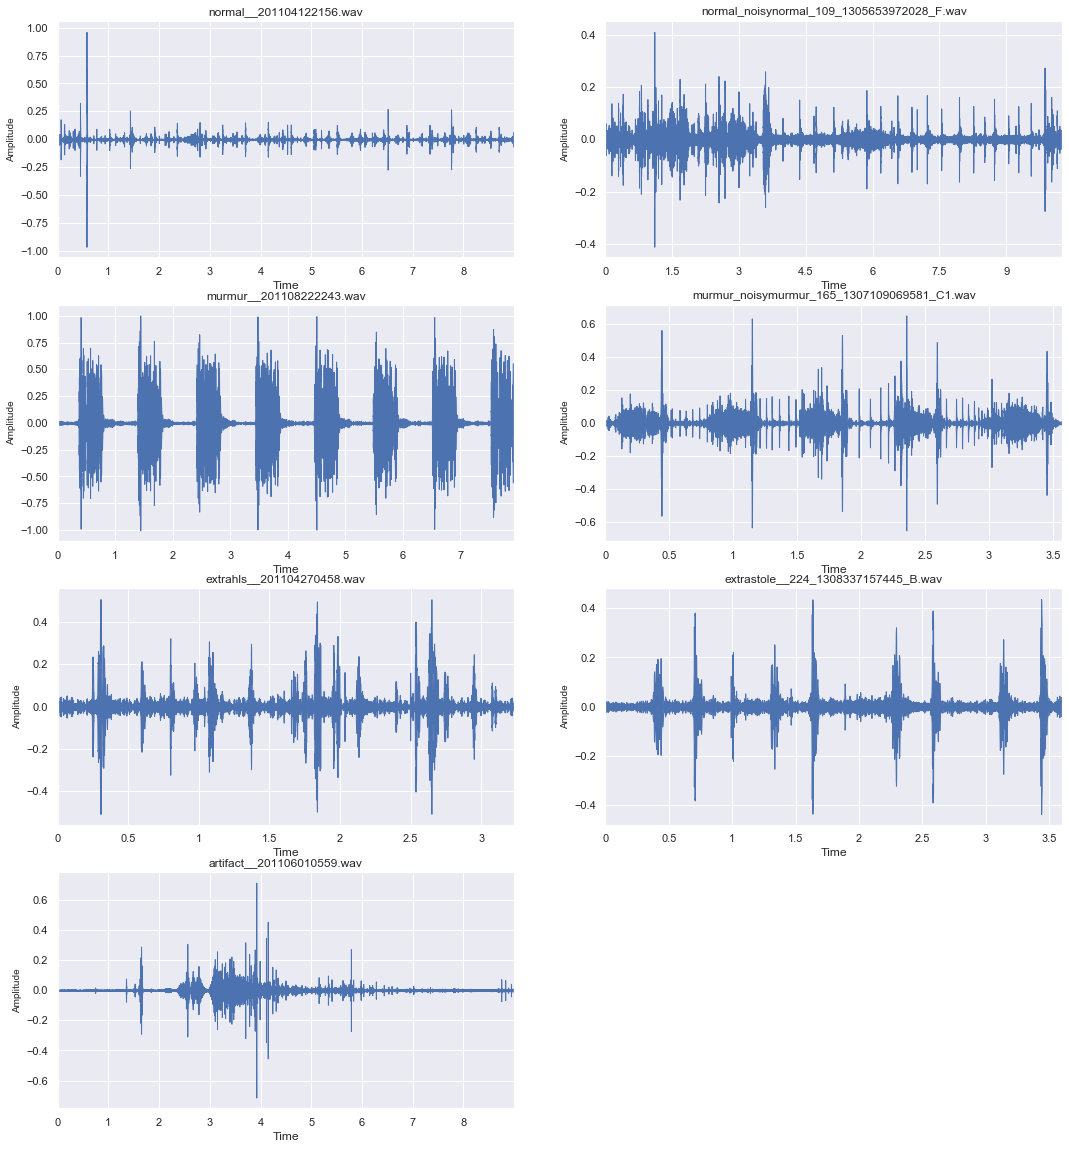

In [27]:
### Visualize all categories of heartbeat sound provided

select = [a_wav[14], b_wav[3], a_wav[11], b_wav[29], a_wav[18], b_wav[54], a_wav[10]]

fig = plt.subplots(figsize = (18,20))

for i in range(1,8):
    subplot(4,2,i)
    data, sr = lr.load(select[i-1])
    lr.display.waveplot(data, sr)
    
    plt.ylabel('Amplitude', fontsize =10)
    plt.title(select[i-1][29:], fontsize =12)


### 1.2.2 EDA on normal heartbeat audio

**Normal Category of heartbeat**
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute). Note the temporal description of “lub” and “dub” locations over time in the following illustration:

…lub……….dub……………. lub……….dub……………. lub……….dub……………. lub……….dub…

In medicine we call the **lub** sound "**S1**" and the **dub** sound "**S2**". Most normal heart rates at rest will be between about 60 and 100 beats (‘lub dub’s) per minute. However, note that since the data may have been collected from children or adults in calm or excited states, the heart rates in the data may vary from 40 to 140 beats or higher per minute. Dataset B also contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. 

Duration of audio wav file: 7.94 sec


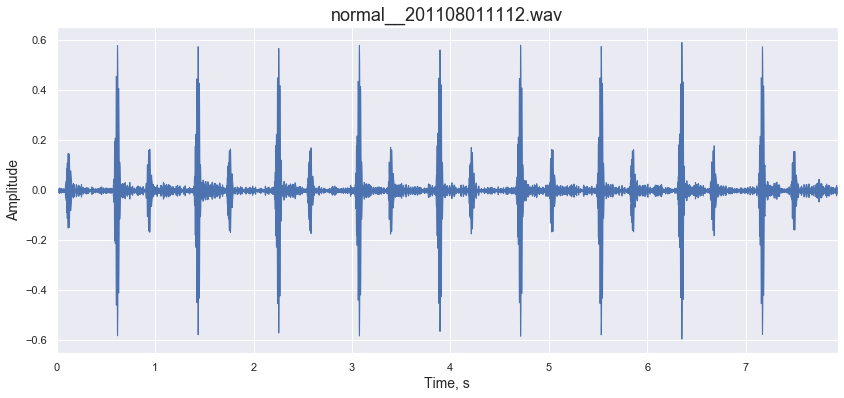

In [28]:
### Plot audio from a_wav[0]
data, sfreq, dur = time_plot(a_wav[0])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [29]:
### Listen to the audio from a_wav[0]

ipd.Audio(a_wav[0])

Visual inpection on the audio in frequency domain (Frequency Spectrum)

The frequency spectrum shown in below graph observed that:
- the heart beat sound is at around 60Hz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


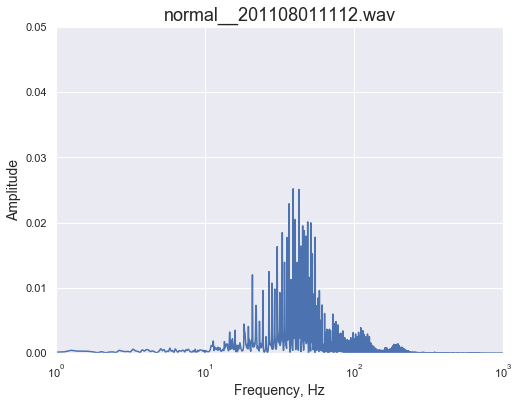

In [30]:
fft_plot(a_wav[0])

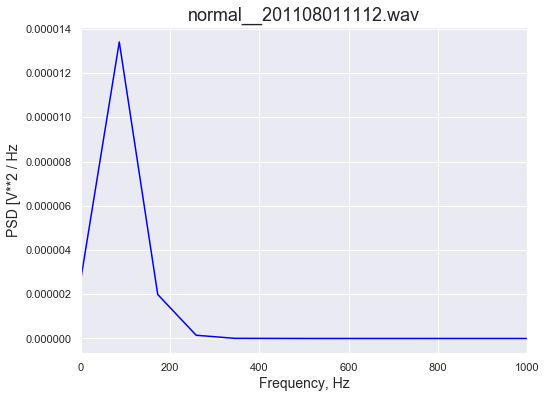

In [31]:
psd_plot(a_wav[0])

### 1.2.3 EDA on murmur heartbeat audio

Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub. Below, you can find `''''` at the locations a murmur may be.

…lub..`''''`...dub……………. lub..`''''`..dub ……………. lub..`''''`..dub ……………. lub..`''''`..dub …

or

…lub……….dub…`''''''`….lub………. dub…`''''''`….lub ………. dub…`''''''`….lub ……….dub…

Dataset B also contains noisy_murmur data - murmur data which includes a substantial amount of background noise or distortion.

Duration of audio wav file: 7.94 sec


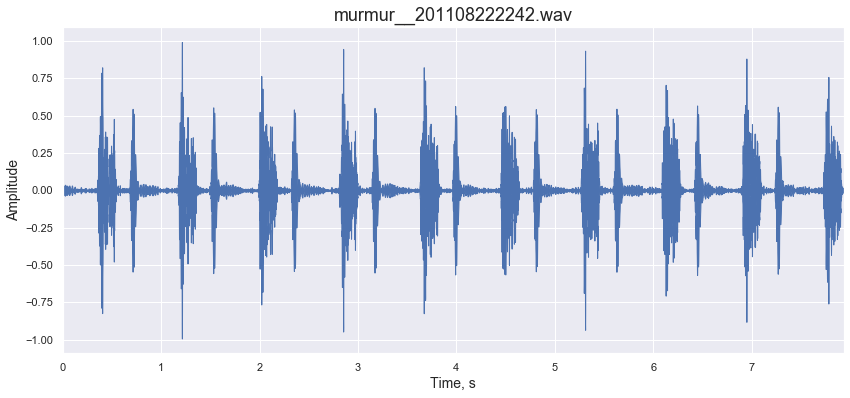

In [32]:
### Plot audio from a_wav[9]
data, sfreq, dur = time_plot(a_wav[9])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [33]:
ipd.Audio(a_wav[9])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at around 60Hz.
- murmurs heard after S1 (lub), and at around 300Hz, the smaller peak in the fft plot shown below.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


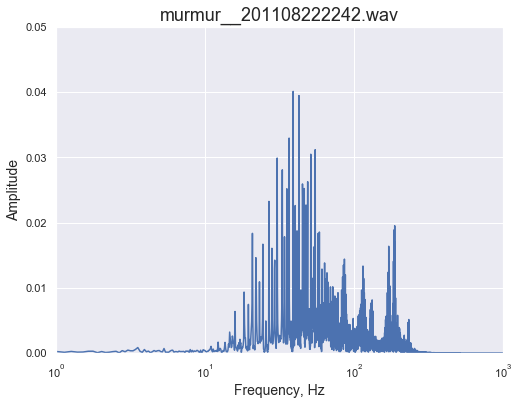

In [34]:
fft_plot(a_wav[9])

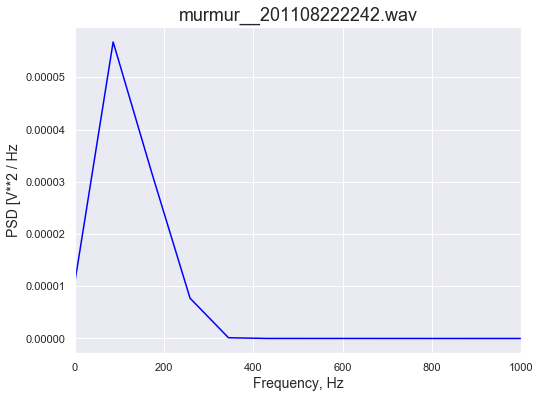

In [35]:
psd_plot(a_wav[9])

### 1.2.4 EDA on Extra Heart Sound (set a)

Extra heart sounds can be identified because there is an additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”. An extra heart sound may not be a sign of disease.  However, in some situations it is an important sign of disease, which if detected early could help a person.  The extra heart sound is important to be able to detect as it cannot be detected by ultrasound very well. Below, note the temporal description of the extra heart sounds:

…lub.lub……….dub………..………. lub. lub……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub.dub………………….lub.……….dub.dub………………….lub……..…….dub. dub……

Duration of audio wav file: 7.88 sec


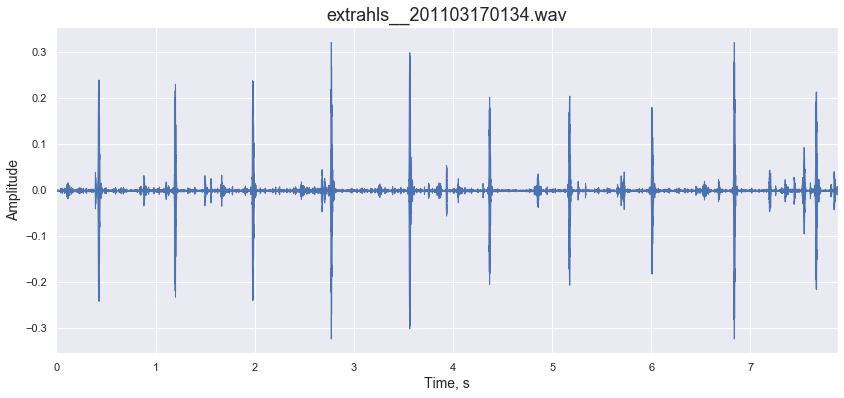

In [36]:
### Plot audio from a_wav[5]
data, sfreq, dur = time_plot(a_wav[5])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [37]:
ipd.Audio(a_wav[5])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 200-300Hz.
- extra S2 (dub) heard after S2, which in above time series plot, there are >1 small peak after the big peak.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


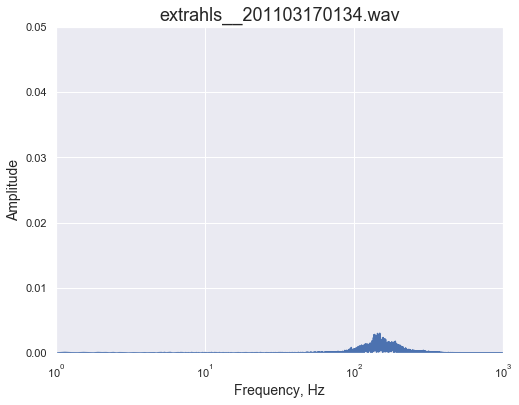

In [38]:
fft_plot(a_wav[5])

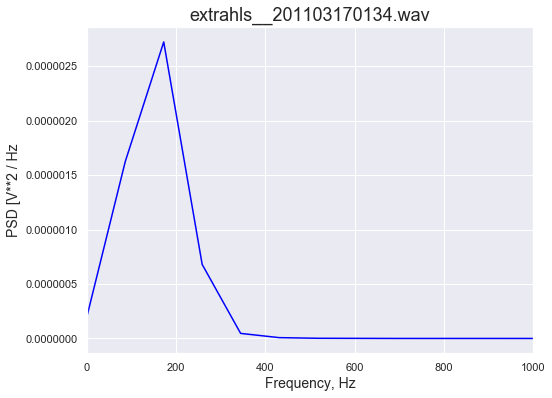

In [39]:
psd_plot(a_wav[5])

### 1.2.5 EDA on Artifact Category (set a)

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.

Duration of audio wav file: 9.0 sec


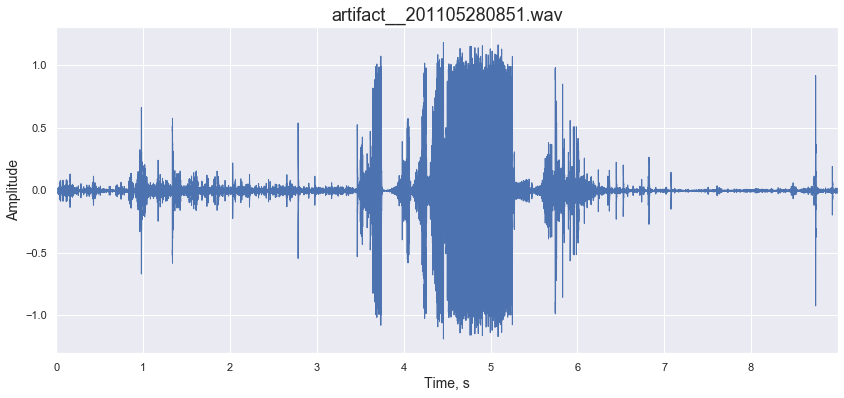

In [40]:
### Plot audio from a_wav[7]
data, sfreq, dur = time_plot(a_wav[7])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [41]:
ipd.Audio(a_wav[7])

Visual inpection on the audio in both frequency domain and time domain:
- there are barely heart sound heard, mainly with various type of noise. No periodic signal observed in time domain and the frequency spread from low frequency up to beyond 1kHz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


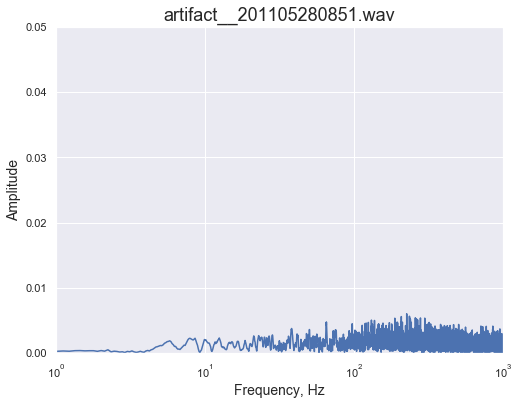

In [42]:
fft_plot(a_wav[7])

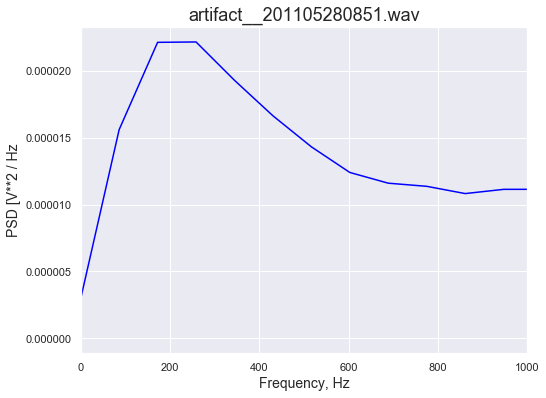

In [43]:
psd_plot(a_wav[7])

### 1.2.6 EDA on Extrasystole (set b)

Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. Below, note the temporal description of the extra heart sounds:

…........lub……….dub………..………. lub. ………..……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub......………………….lub.…………………dub.dub………………….lub……..…….dub.……

Duration of audio wav file: 5.64 sec


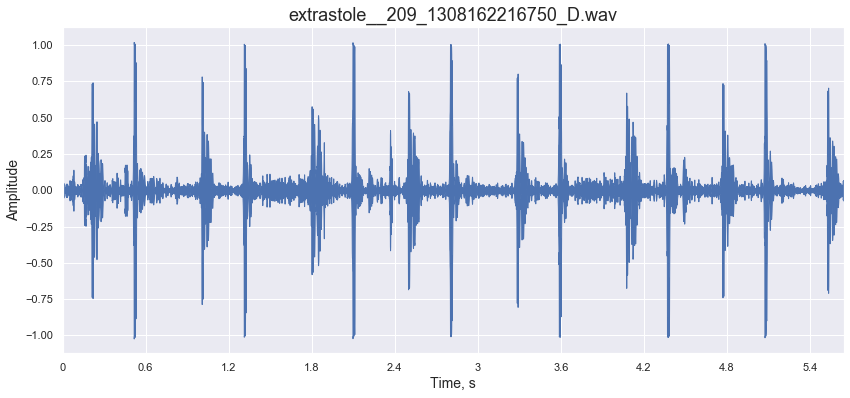

In [44]:
### Plot audio from b_wav[23]
data, sfreq, dur = time_plot(b_wav[23])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [45]:
ipd.Audio(b_wav[23])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 80Hz.
- it is not easy to hear the extrasystole sounds, it seems appeared at around 2.4s in the tim-series plot

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


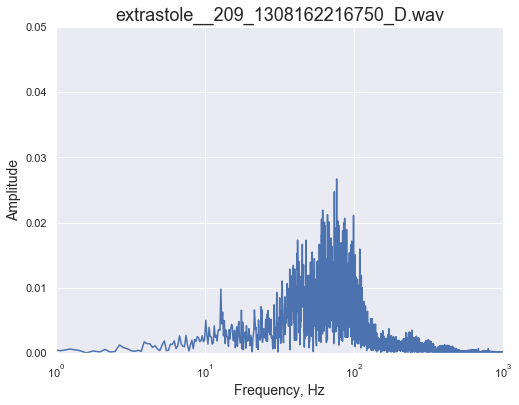

In [46]:
fft_plot(b_wav[23])

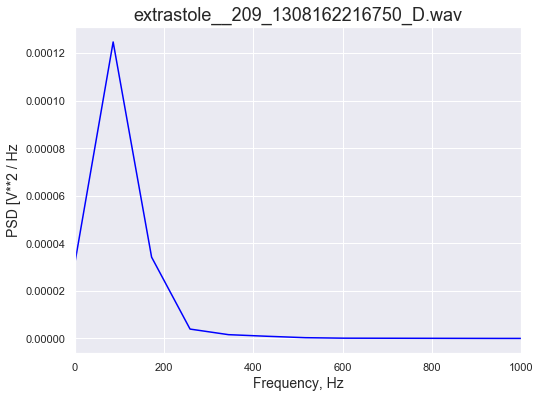

In [47]:
psd_plot(b_wav[23])

# 2.0 Pre-processing

The original recorded wav files in both set A and set B have certain level of contatimnation with background noise. This is observed especially in the frequency domain spectrum in EDA. Thus, we'll need to clean the wav file to only contain as much of the wanted audio signal (i.e. the S1 & S2 heartbeat sound) before modeling.

In addition, the hearbeat sound is non-stationary signal (how to prove?), which is bad if we were to model using jsut the Fourier Transform spectrum.

## 2.1 Denoise audio signal

From EDA, we can hear that the recorded audio is masked with background noise. This could make it hard to detect the S1 and S2 signal.

**Denoise** by removing (high-frequency) noise using **Discrete Wavelet Transform** (DWT)

DWT is implemented as a filter-bank which can deconstruct a signal into its frequency sub-bands. It can desconstruct the noisy signal into the approximation (low pass) and detail (high pass) coefficients. 
To filter out the unwanted high frequency noise, setting the detail coefficients to zero to filter out that part of the high frequency spectrum. This can be done by using `pywt.threshold()`, which removes coefficient values higher than a given threshold. Then, reconstruct the signal again from teh remaining coefficients.


source:

[Guide using wavelet transformation in machine learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

[pywavelets](https://pywavelets.readthedocs.io/en/latest/)

In [48]:
### The PyWavelets library contains 14 mother Wavelets (families of Wavelets):
### A wavelet must have 1) finite energy and 2) zero mean.
### For heartbeat sound, I will use the 'Daubechies' Wavelets to decompose as it has 
### characteristics closes to the heartbeat sound

print(pywt.families(short=False))


['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Within each wavelet family there can be a lot of different wavelet subcategories belonging to that family. You can distinguish the different subcategories of wavelets by the number of coefficients (the number of vanishing moments) and the level of decomposition.

This is illustrated below in for **‘Daubechies’** (short-form, db), the wavelet family that I selected to decompose the heartbeat audio.

In [49]:
### list of wavelet sub-categories
#pywt.wavelist()

['db6', 'db7', 'db8', 'db9', 'db10']


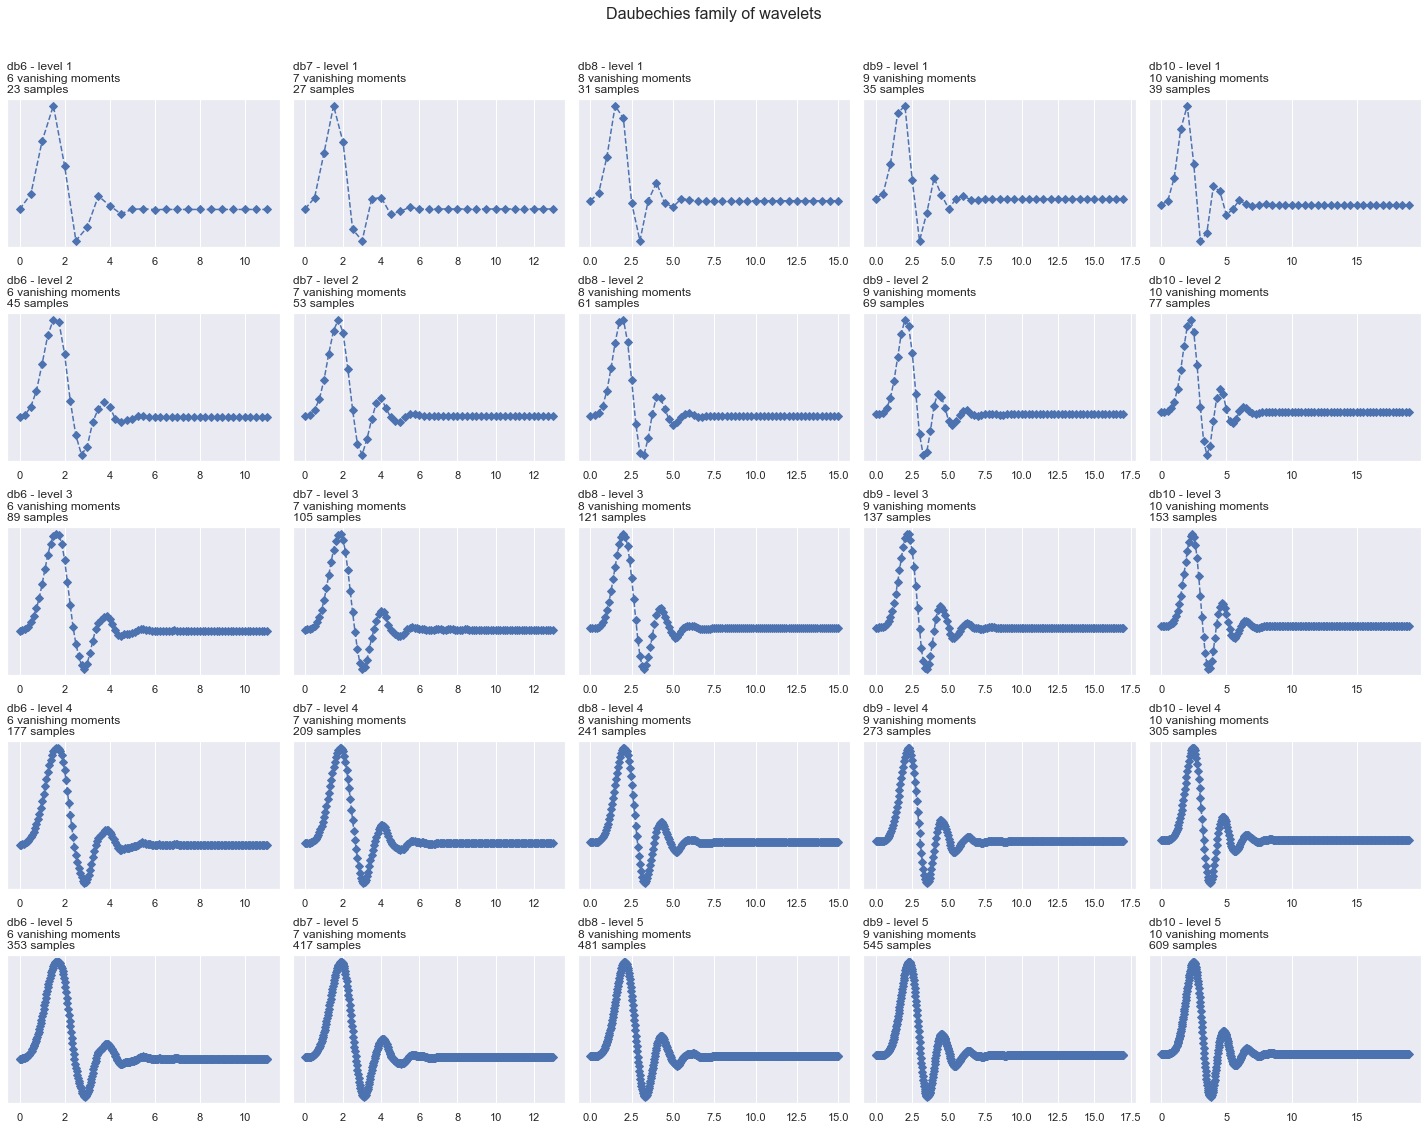

In [50]:
#import pywt
#import matplotlib.pyplot as plt
 
db_wavelets = pywt.wavelist('db')[5:10]
print(db_wavelets)

 
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Deconstructing a signal using DWT

#### Search for wavelet subcategories and level, based on one wav file (plot shown in the subsequent cell)

- Tweak the wavelet list (from db1 and up, which increases the vanishing moment).
- Tweak the level to reduce the noise
- Tweak the threshold to include the small peak as much as possible

In [51]:
### Define function to remove the high frequency using DWT

def denoise_signal(x, wavelet='db6', level = 8):
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet=wavelet, mode="per", level= level)
     
    # Calculte the univeral threshold
    # the 0.3 value is tweak until I can reconstruct all the peak (without lefting out the small peak)
    thresh = 0.3 * np.nanmax(x)       
    coeff[1:] = ( pywt.threshold( i, value=thresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet = wavelet, mode='per' )
    

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


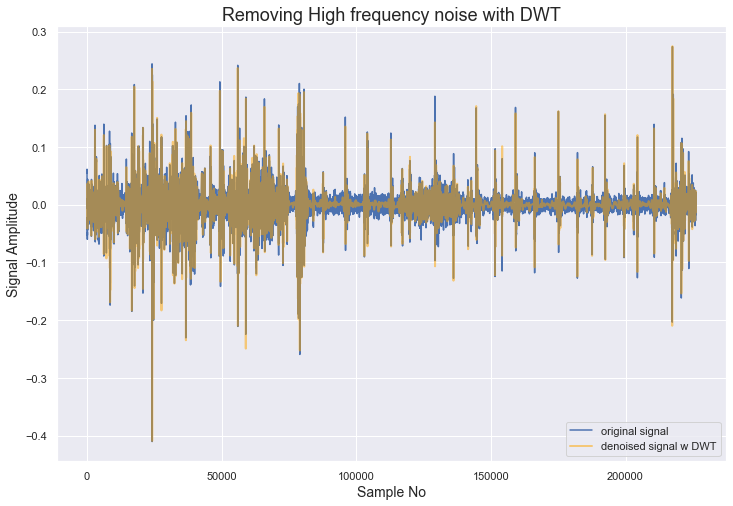

In [52]:
### denoise the signal, tweak the wavlet subcategories (this wave is use to tweak the wavelet subcategories and threshold)

### try the signal from set_b, noisy normal
signal, sr = lr.load(b_wav[3])

### this is the denoised signal
rec = denoise_signal(signal)

### plot original and denoised signal in TIME DOMAIN
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(signal, color = 'b', label = 'original signal');

ax.plot(rec, 'orange', alpha = 0.5, label = 'denoised signal w DWT', linewidth =2);
ax.legend()

ax.set_title('Removing High frequency noise with DWT', fontsize = 18)
ax.set_ylabel('Signal Amplitude', fontsize = 14)
ax.set_xlabel('Sample No', fontsize = 14)
plt.show()


In [53]:
### Define function to calculate the signal to noise ratio (SNR)
### Check how well the denoise

def snr(signal, thresh):
    thresh = thresh * np.nanmax(signal)
    
    ### extract the signal exceed the threshold
    signal_sq = [i**2 for i in signal if i >= thresh]
    signal_rms =  np.sqrt(sum(signal_sq) / len(signal_sq))
    
    ### calculate the noise (i.e. data not included in signal above)
    noise_sq = [i**2 for i in signal if i < thresh]
    noise_rms = np.sqrt(sum(noise_sq) / len(noise_sq))
    #noise_rms = signal.std(axis =0, ddof =0)
    
    return 20*np.log10(signal_rms/noise_rms)


In [54]:
### original wav
ipd.Audio(b_wav[3])

In [55]:
### denoised wav
ipd.Audio(rec, rate=sr)

In [56]:
### SNR of original signal (b_wav[3]) - this is one of the noisy normal audio
snr(signal, 0.5)

17.371561085122448

In [57]:
### SNR of denoised signal
snr(rec, 0.5)

17.833079714089656

In [58]:
### Define plot function to plot the frequency spectrum of the de-noised signal

def simfft_plot(signal, sfreq, label):
    n = len(signal)
    
    #check if the len of audio data is odd number
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
    
    t = 1/sfreq
    yf = scipy.fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)
    plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), label = label)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()


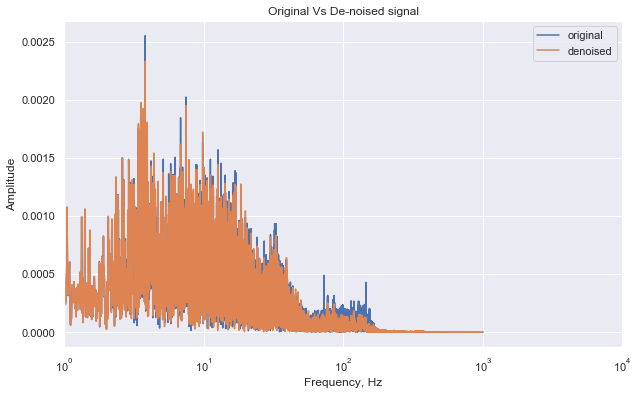

In [59]:
### plot the de-noised signal in FREQUENCY DOMAIN
### Denoise remove the high frequency signal only

plt.subplots(figsize=(10,6))
simfft_plot(signal, 2000, 'original');
simfft_plot(rec, 2000, 'denoised');
plt.xscale('log')
plt.xlim(1, 10000)
plt.legend(loc = 1);
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude')
plt.title('Original Vs De-noised signal');


### Denoised 5 wav from each folder and plot the signal in time domain

- the selected wavelet and threshold setting not done well on some wav where there is extremely small peak

In [60]:
### load first 10 audio wav in set_a into array using librosa, and store in y_a
y_a = []

for i in range(10):
    y = lr.load(a_wav[i], res_type = 'kaiser_fast')   # use kaiser_fast technique for faster extraction
    y_a.append(y)
    
len(y_a)

10

In [61]:
### load first 10 audio wav in set_b into array using librosa, and store in y_b
y_b = []

for i in range(10):
    y = lr.load(b_wav[i], sr = None, res_type = 'kaiser_fast')  # load with its original sampling rate (i.e. 4kHz)
    y_b.append(y)
    
len(y_b)

10

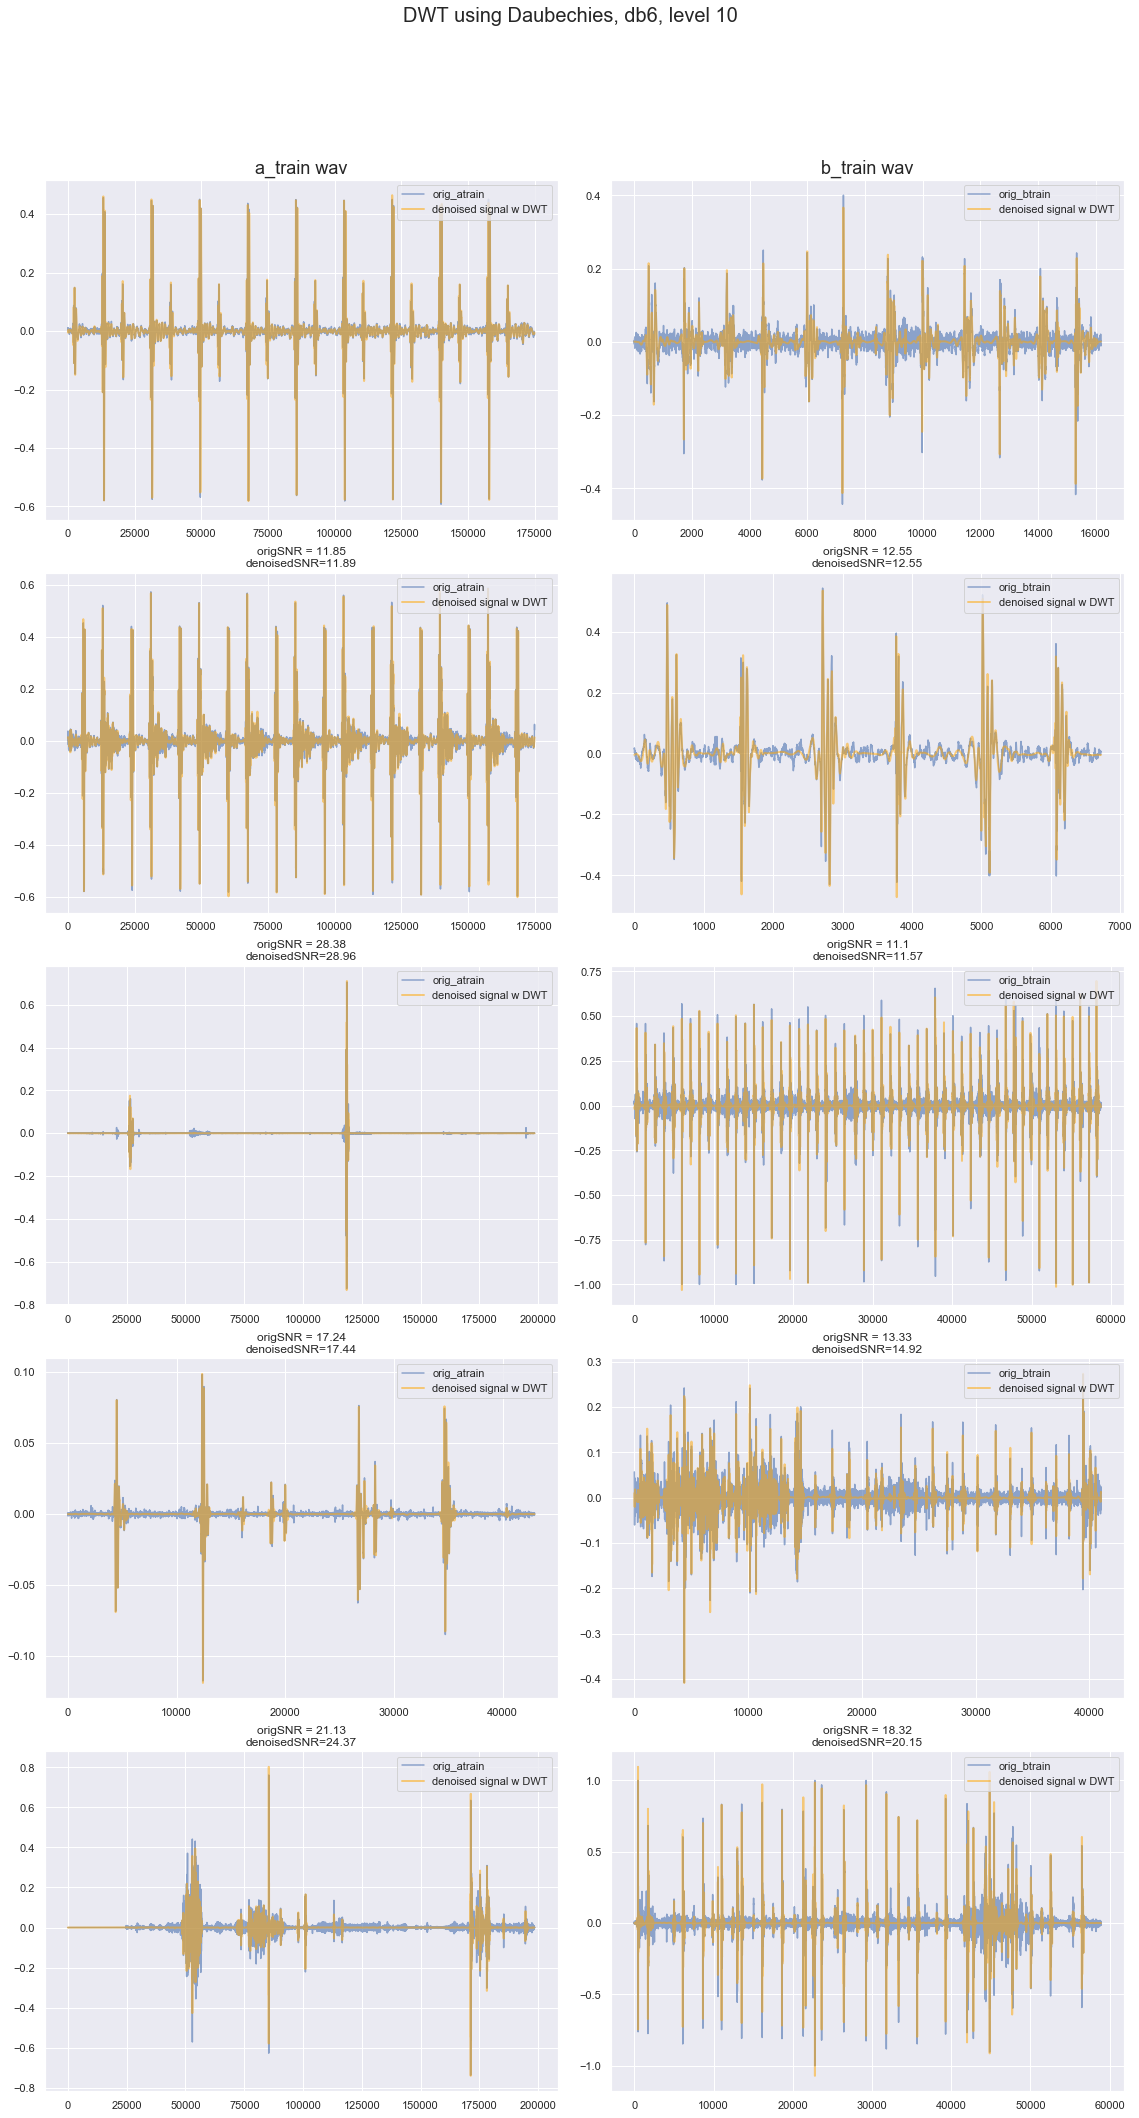

In [62]:
fig, ax = plt.subplots (ncols = 2, nrows = 5, figsize = (16, 30))
fig.suptitle('DWT using Daubechies, db6, level 10', fontsize = 20)

for i in range(5):
    signala = y_a[i][0]
    signalb = y_b[i][0]
    
    ### this is the denoised signal
    rec_a = denoise_signal(signala)
    rec_b = denoise_signal(signalb)
    
    ### plot original and denoised signal in TIME DOMAIN
    ax[i,0].plot(signala, color = 'b', alpha = 0.6, label = 'orig_atrain');
    ax[i,0].plot(rec_a, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,0].set_title(f"origSNR = {round(snr(signala, 0.2),2)}\ndenoisedSNR={round(snr(rec_a, 0.2),2)}")
    ax[i,0].legend(loc =1)
    
    ax[i,1].plot(signalb, color = 'b', alpha = 0.6, label = 'orig_btrain');
    ax[i,1].plot(rec_b, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,1].set_title(f"origSNR = {round(snr(signalb, 0.2),2)}\ndenoisedSNR={round(snr(rec_b, 0.2),2)}")
    ax[i,1].legend(loc =1)
    

ax[0,0].set_title("a_train wav", fontsize=18);
ax[0,1].set_title("b_train wav", fontsize=18);
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 2.2 Feature Selection
- Spectrogram
- MFCC

### 2.2.1 Spectrogram

So far, we only view the signal in either time domain or frequency domain, which, if in time domai, there is no information about how the signal change in time, and vice versa. 

A spectrogram is a visual representation of the spectrum of frequencies of signal as it vary with time. It’s a representation of frequencies changing with respect to time for signal.

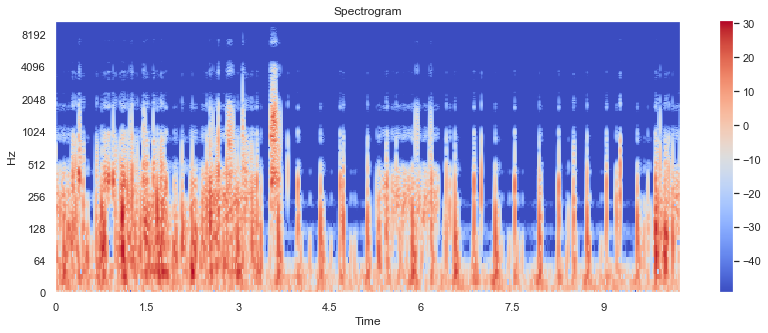

In [63]:
### Visualize the spectrogram with the down-sampled, DWT signal from btrain_wav[1]
### The spectrogram seems strange

### calculate the short-time fourier transform
X = lr.stft(rec)     

### convert the signal to log-scale
Xdb = lr.amplitude_to_db(abs(X))

### plot the spectrogram
plt.figure(figsize=(14, 5))
lr.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis ='log');  
plt.title('Spectrogram')
plt.colorbar();


### 2.2.2 MFCC

Mel Frequency Cepstral Coefficient (MFCC) is by far the most successful feature used in the field of Speech Processing. Speech is a non-stationary signal. As such, normal signal processing techniques cannot be directly applied to it.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly derived as follows: -Take the Fourier transform of (a windowed excerpt of) a signal. -Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows. -Take the logs of the powers at each of the mel frequencies. -Take the discrete cosine transform of the list of mel log powers, as if it were a signal. The MFCCs are the amplitudes of the resulting spectrum.

In general, a 39-dimensional feature vector is used which is composed of first 13 MFCCs and their corresponding 13 delta and 13 delta-delta.


source: [Heart sounds analysis and classification with LSTM](https://www.kaggle.com/mychen76/heart-sounds-analysis-and-classification-with-lstm)

[librosa.feature.mfcc](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)

[mfcc](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)

[mfcc tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [64]:
# Here's a sample generate mfccs from the SAME, down-sampled, DWT signal from btrain_wav[1]
#y, sr = lr.load(btrain_wav[1])
mfccs = lr.feature.mfcc(y = rec, sr = sr, n_mfcc= 40)
print(mfccs.shape)

(40, 442)


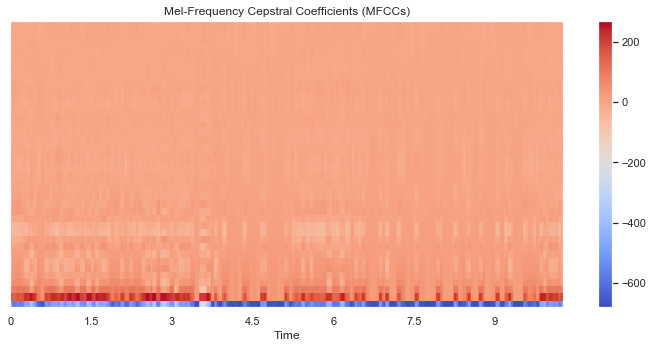

In [65]:
# Visualize the MFCCs

plt.figure(figsize = (10,5))
lr.display.specshow(mfccs, x_axis= 'time')
plt.colorbar()
plt.title('Mel-Frequency Cepstral Coefficients (MFCCs)')
plt.tight_layout()

In [66]:
# Use a pre-computed log-power Mel spectrogram  (Compute a mel-scaled spectrogram)
S = lr.feature.melspectrogram(y = rec, sr = sr, fmax=8000, n_mels =128)
Sdb = lr.power_to_db(S, ref = np.max)
print(Sdb.shape)

(128, 442)


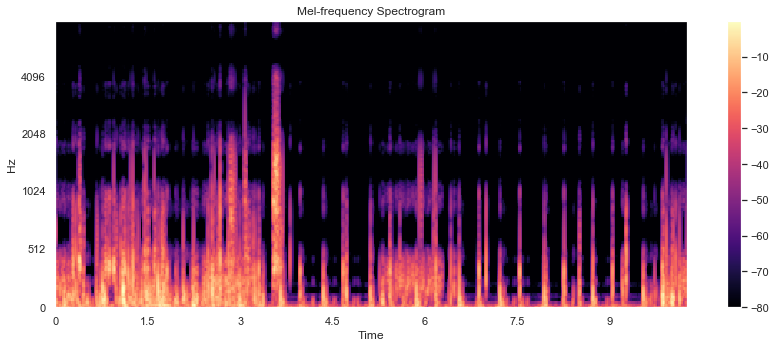

In [67]:
# Visualize the MFCCs. Similar to spectrogram, it seems strange as the time seems divided into 9 bins

plt.figure(figsize=(12, 5))
lr.display.specshow(Sdb, x_axis = 'time', y_axis='mel', sr = sr, fmax=8000)
plt.colorbar()
plt.title('Mel-frequency Spectrogram')
plt.tight_layout()
plt.show()

## 2.3 Preparing features matrix and y label

In [68]:
### Compile dataset for filename, filepath (for the wav file) and its label

dataset = []

for i in range(len(a_wav)):
    label = a_wav[i].split("/")[4].split("__")[0]
    filename = a_wav[i].split("/")[4].split("__")[1]
    filepath = a_wav[i]
    y, sr = lr.load(a_wav[i])
    ### drop wav that is <4 sec
    if lr.get_duration(y=y, sr=sr) >= 4:
        ### drop unlabeled wav
        if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
            dataset.append({
                            'filename' : filename,
                            'label' : label,
                            'filepath' : filepath
                            })   

In [69]:
df_a = pd.DataFrame(dataset)
df_a.head()

filename     label  \
0  201108011112.wav    normal   
1  201012172012.wav  artifact   
2  201103170134.wav  extrahls   
3  201105280851.wav  artifact   
4  201108222256.wav    murmur   

                                            filepath  
0  ../datasets/challenge2/set_a/normal__201108011...  
1  ../datasets/challenge2/set_a/artifact__2010121...  
2  ../datasets/challenge2/set_a/extrahls__2011031...  
3  ../datasets/challenge2/set_a/artifact__2011052...  
4  ../datasets/challenge2/set_a/murmur__201108222...

In [70]:
df_a.shape

(118, 3)

In [71]:
### Define function to denoise signal and extract feautre : mfcc 

def extract_features(audio_path):
    y, sr = lr.load(audio_path, duration =4)
    y_denoise = denoise_signal(y)
    mfccs = lr.feature.mfcc(y = y_denoise, sr = sr, n_mfcc=40)
    return mfccs

In [72]:
%%time
### Denoise and extract mfcc as feature matrix X_a

X_a =[]
for i in range(len(df_a)):
    X_a.append(extract_features(df_a['filepath'].loc[i]))
    

CPU times: user 39.1 s, sys: 2.25 s, total: 41.4 s
Wall time: 21.9 s


In [73]:
X_a = np.asarray(X_a)
X_a.shape

(118, 40, 173)

In [74]:
### Extract label as target y and one-hot encode to integer

y = df_a.label

le= LabelEncoder()
y = le.fit_transform(y)

## to get back, use le.inverse_transform(y)

#### Train test split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size = 0.2, shuffle = True,
                                                   stratify = y, random_state=True)

In [76]:
X_train.shape

(94, 40, 173)

#### Compute class weight

In [77]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.734375  , 1.95833333, 0.90384615, 0.97916667])

#### Re-shape 

In [78]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### change int categorical to dummies
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (94, 40, 173, 1)
X_test : (24, 40, 173, 1)
y_train : (94, 4)
y_test : (24, 4)


## 3 Modelling

### CNN

In [79]:
### Build model

model = Sequential()

# add 1st convolutional layer
model.add(Conv2D(filters = 16, kernel_size = 2, activation = 'relu', 
                 input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D(pool_size = 2))
# add 2nd convoluational layer
model.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.1))
# add 3rd convoluational layer
model.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.1))
# add 4th convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(le.classes_), activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)         8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 20, 64)        

#### Compile model

In [80]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### Fit model

In [81]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs = 100, batch_size=128, class_weight=class_weights, shuffle = True, verbose = 2)

Train on 94 samples, validate on 24 samples
Epoch 1/100
 - 1s - loss: 24.5935 - accuracy: 0.1277 - val_loss: 12.9662 - val_accuracy: 0.2500
Epoch 2/100
 - 0s - loss: 16.1913 - accuracy: 0.2553 - val_loss: 6.9353 - val_accuracy: 0.2500
Epoch 3/100
 - 0s - loss: 8.7331 - accuracy: 0.2872 - val_loss: 7.2315 - val_accuracy: 0.2917
Epoch 4/100
 - 0s - loss: 8.0377 - accuracy: 0.2979 - val_loss: 6.2851 - val_accuracy: 0.4583
Epoch 5/100
 - 0s - loss: 6.9781 - accuracy: 0.3723 - val_loss: 6.8044 - val_accuracy: 0.2917
Epoch 6/100
 - 0s - loss: 9.6505 - accuracy: 0.3511 - val_loss: 6.9731 - val_accuracy: 0.3333
Epoch 7/100
 - 0s - loss: 9.7158 - accuracy: 0.3404 - val_loss: 5.3231 - val_accuracy: 0.2917
Epoch 8/100
 - 0s - loss: 8.1341 - accuracy: 0.3617 - val_loss: 3.5453 - val_accuracy: 0.4583
Epoch 9/100
 - 0s - loss: 5.1303 - accuracy: 0.3191 - val_loss: 3.2559 - val_accuracy: 0.4583
Epoch 10/100
 - 0s - loss: 3.2569 - accuracy: 0.4574 - val_loss: 2.6439 - val_accuracy: 0.4583
Epoch 11/100

Epoch 87/100
 - 0s - loss: 0.7060 - accuracy: 0.6915 - val_loss: 0.7278 - val_accuracy: 0.7083
Epoch 88/100
 - 0s - loss: 0.6484 - accuracy: 0.7872 - val_loss: 0.7122 - val_accuracy: 0.7083
Epoch 89/100
 - 0s - loss: 0.6348 - accuracy: 0.7128 - val_loss: 0.6936 - val_accuracy: 0.7083
Epoch 90/100
 - 0s - loss: 0.6382 - accuracy: 0.7660 - val_loss: 0.6689 - val_accuracy: 0.7083
Epoch 91/100
 - 0s - loss: 0.5865 - accuracy: 0.7340 - val_loss: 0.6629 - val_accuracy: 0.7083
Epoch 92/100
 - 0s - loss: 0.6429 - accuracy: 0.7234 - val_loss: 0.6742 - val_accuracy: 0.7083
Epoch 93/100
 - 0s - loss: 0.6476 - accuracy: 0.7340 - val_loss: 0.6792 - val_accuracy: 0.7083
Epoch 94/100
 - 0s - loss: 0.6002 - accuracy: 0.7660 - val_loss: 0.6654 - val_accuracy: 0.7500
Epoch 95/100
 - 0s - loss: 0.5939 - accuracy: 0.7766 - val_loss: 0.6413 - val_accuracy: 0.7083
Epoch 96/100
 - 0s - loss: 0.6977 - accuracy: 0.7021 - val_loss: 0.6348 - val_accuracy: 0.7083
Epoch 97/100
 - 0s - loss: 0.6991 - accuracy: 0.63

#### Loss and Accuracy Score

Text(0.5, 1.0, 'Accuracy Curve')

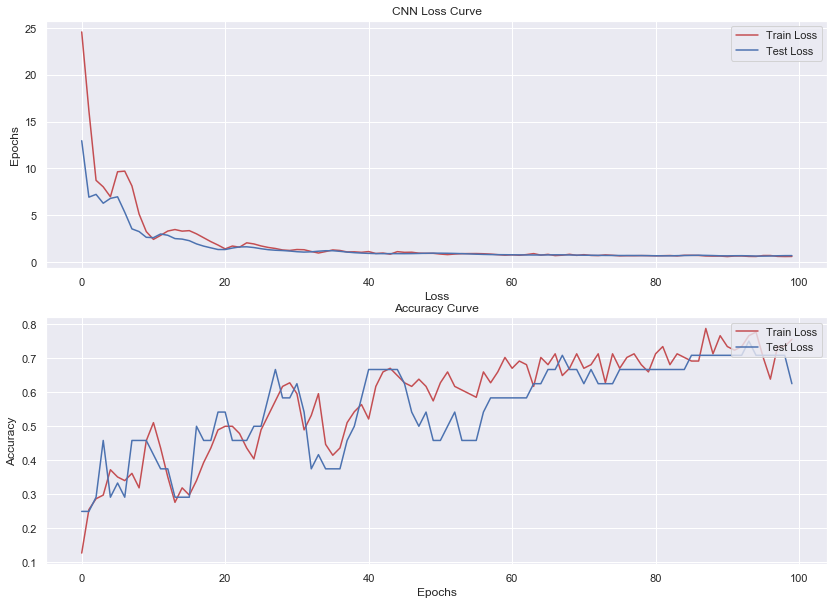

In [82]:
plt.figure(figsize = (14,10))
plt.subplot(211)
plt.plot(history.history['loss'], 'r', label = 'Train Loss')
plt.plot(history.history['val_loss'], 'b', label = 'Test Loss')
plt.legend(loc=1)
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title('CNN Loss Curve')

plt.subplot(212)
plt.plot(history.history['accuracy'], 'r', label = 'Train Loss')
plt.plot(history.history['val_accuracy'], 'b', label = 'Test Loss')
plt.legend(loc=1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')

In [83]:
### X_test loss and accuracy score

model_score = model.evaluate(X_test, y_test, verbose =2)
model_labels = model.metrics_names

print(f'cnn {model_labels[0]}: {model_score[0]}')
print(f'cnn {model_labels[1]}: {model_score[1]}')

cnn loss: 0.6881980895996094
cnn accuracy: 0.625


#### Model prediction and evaluation on X_test

In [84]:
### Predict the X_test
pred = model.predict_classes(X_test)

### Compile predicted results
y_true, y_pred = [], []
classes = le.classes_

for idx, preds in enumerate(pred):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[preds])

In [85]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    artifact       1.00      0.88      0.93         8
    extrahls       0.29      0.67      0.40         3
      murmur       0.83      0.71      0.77         7
      normal       0.25      0.17      0.20         6

    accuracy                           0.62        24
   macro avg       0.59      0.61      0.58        24
weighted avg       0.67      0.62      0.64        24



In [86]:
### View the class with WRONG classificaiton 
cnn_pred_result = list(zip(y_true, y_pred))
cnn_result_df = pd.DataFrame(cnn_pred_result, columns = ['label', 'pred_label'])
cnn_result_df[cnn_result_df['label'] != cnn_result_df['pred_label']]

label pred_label
0     murmur     normal
1     murmur   extrahls
11    normal   extrahls
12    normal   extrahls
14    normal     murmur
17    normal   extrahls
18    normal   extrahls
19  artifact     normal
22  extrahls     normal

#### Confusion Matrix

In [87]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

    plt.show()

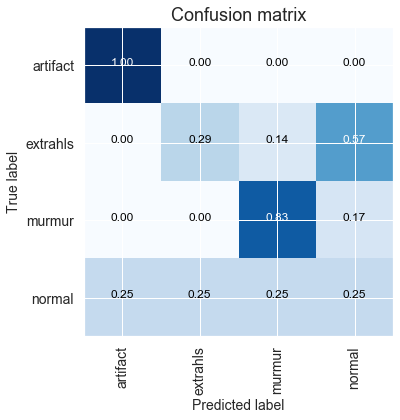

In [88]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)